In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import re
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, models, losses, InputExample, evaluation, SentencesDataset
import numpy as np
import pandas as pd
from torch import nn

## Dataset Preparation
We have used the Qoura Question Pairs that has 404290 questions pairs and their labels.
The data contains the following fields:

- id: the id of a training set question pair
- qid1, qid2: unique ids of each question
- question1, question2: the full text of each question (**This is our X**)
- is_duplicate: the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise (**This is our Y**).

In [72]:
df = pd.read_csv(fr"/content/drive/MyDrive/Project/train.csv")
print(df.head())
print(len(df))

# Features (X)
'''
We took a small chunk (120k pairs) from our dataset since it's a huge amount of data
that required a lot of computing. Upon calculations, it was expected to take around
22hours (without GPU) on our mahcines =( . Hence, we unanimously decided to run it over
120k chunk
'''
X = df[["question1", "question2"]].values.tolist()[0:120000]
print(X[0])

# Labels (Y)
Y = df['is_duplicate'].tolist()[0:120000]
print(Y)

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
404290
['What is the step by step guide to invest in share market in india?', 'What is the step by step guide to invest in share market?']
[0, 0, 0, 0, 0

In [73]:
# Pre-Processing:

'''
We might lose the context of the sentence if we remove the stop words. For exmaple, "This
movie is not good." will become "movie good" after getting stop words removed from it
which totally changed the meaning of the sentence. Hence, we didn't go for removing
stop words from our text in pre-processing. But, to reduce the token length, we removed numeric digits, URLs,
and special charaters. We also converted every character into the lower case.
'''

# Lower Casing everything
for i in X:
  i[0] = str(i[0]).lower()
  i[1] = str(i[1]).lower()

# Removing numbers
for i in X:
  i[0] = re.sub(r'\d', '', str(i[0]))
  i[1] = re.sub(r'\d', '', str(i[1]))

# Removing the special characters:
for i in X:
  i[0] = re.sub(r'[^a-zA-Z\s]', '', str(i[0]))
  i[1] = re.sub(r'[^a-zA-Z\s]', '', str(i[1]))

# removing URLs:
for i in X:
  i[0] = re.sub(r'http\S+', '', str(i[0]))
  i[1] = re.sub(r'http\S+', '', str(i[1]))

print(X)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Test-Train Split

In [74]:
X_train = X[0:90000]
Y_train = Y[0:90000]

X_val = X[90000:120000]
Y_val = Y[90000:120000]

## Creating the embeddings
For embedding calculation, we're using [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf). The reason for using SBERT is that it's computationaly inexpensive (as compared to its parent model BERT or RoBERT). It reduces the effort for finding semantic textual similarity from 65 hours with BERT / RoBERTa to about 5 seconds, while maintaining the accuracy from BERT.

You can overview SBERT's architecture along with the approach we followed:
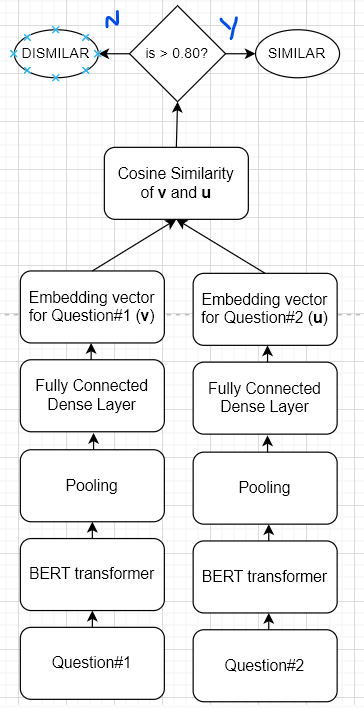

In [75]:
'''
Pre-Trained model: distiluse-base-multilingual-cased-v1
The above model is specifically designed for the Sentence Similarity use case. It maps sentences
to a 512 dimensional dense vector space. It is a distilled version of (Multilingual Universal
Sentence Encode) https://arxiv.org/abs/1907.04307. This model has already been trained over
huge amount of text data.
Full architecture of it is as follows (also described in the image above):
SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)
'''
# Pre-Trained Model Loading
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
transposed_X = list(map(list, zip(*X_train)))

# Generating embedding for each quesrion in the pair
query_embedding = model.encode(transposed_X[0])
passage_embedding = model.encode(transposed_X[1])

print("query_embedding type:",type(query_embedding))  # dim:(90000,512) (embedding of 90k train pairs --> each pair has embedding vector of length 512)
print("passage_embedding type:",type(passage_embedding))  # dim:(90000,512) (embedding of 90k train pairs --> each pair has embedding vector of length 512)

print("query_embedding len:",len(query_embedding))
print("passage_embedding len:",len(passage_embedding))


query_embedding type: <class 'numpy.ndarray'>
passage_embedding type: <class 'numpy.ndarray'>
query_embedding len: 90000
passage_embedding len: 90000


90000
90000
[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 

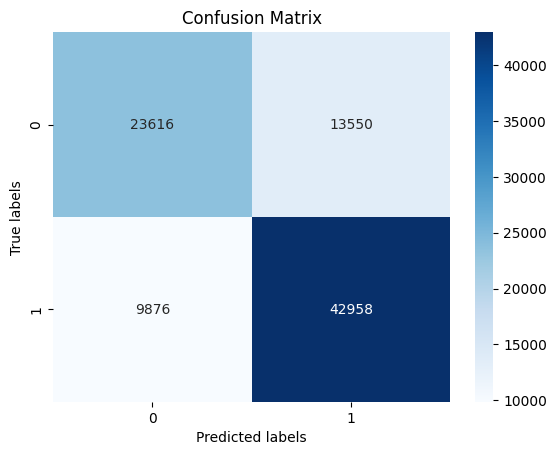

Precision: 0.635419469407523
Recall: 0.7051236116087424
Accuracy: 0.7397111111111111
F1: 0.6684593393529394


In [94]:
# Calculting the cosine similarity of each pair and if that exceeds 0.80,
# then both sentences are similar.
predicted_y = list()
for i in range(0,len(query_embedding)):
  similarity = np.dot(query_embedding[i],passage_embedding[i])/(np.linalg.norm(query_embedding[i])*np.linalg.norm(passage_embedding[i]))
  if similarity >= 0.80:
    predicted_y.append(1)
  else:
    predicted_y.append(0)
  pass

# Just printing dimensions and stuff
print(len(Y_train))
print(len(predicted_y))
print(Y_train)
print(predicted_y)

# Preparing a confusion matrix
conf_mat = np.zeros((2,2))
trues = 0
falses = 0
for i in range(0, len(Y_train)):
  if(int(Y_train[i])==1 and int(predicted_y[i])==1):
    conf_mat[0][0]+=1
  elif(int(Y_train[i])==1 and int(predicted_y[i])==0):
    conf_mat[1][0]+=1
  elif(int(Y_train[i])==0 and int(predicted_y[i])==1):
    conf_mat[0][1]+=1
  elif(int(Y_train[i])==0 and int(predicted_y[i])==0):
    conf_mat[1][1]+=1
  else:
    print("Bhai kuch garbar hai")
print("CONFUSOIN MATRIX:\n", conf_mat)

# Plotting confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculating Precision, Accuracy, Recall, and F1 scores
P = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
print("Precision:", P)
R = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
print("Recall:", R)
A = (conf_mat[0][0]+conf_mat[1][1])/(conf_mat[0][0]+conf_mat[0][1]+conf_mat[1][1]+conf_mat[1][0])
print("Accuracy:", A)
print("F1:", (2*P*R)/(P+R))

## Trend for Pre-Trained model
If we decrease the threshold, the accuracy and precision decreases along but the recall and F1 increases. But that trend is followed till 0.85 threshold.

## Custom Training
Now that we've used a pre-trained model and saw how it performed (without any training, since it was pre-trained), we now wanted to test it on a classifer trained on our Quora Question Pair data. We trained a Logistic Regression model (using L2 loss and over 10000 epochs) with the embeddings generated by the SBERT and tested it (with the val split we made earlier).
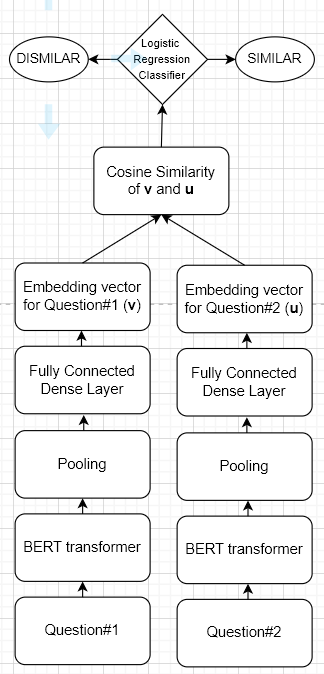

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score

# Getting SBERT embeddings for validation set
transposed_X = list(map(list, zip(*X_val)))
query_embedding_val = model.encode(transposed_X[0])
passage_embedding_val = model.encode(transposed_X[1])


X_train_features.shape: (90000, 1024)
X_val_features (30000, 1024)
Accuracy: 0.7231333333333333
F1 Score: 0.5776896481594468
Precision: 0.6674891317119023
Recall: 0.5091870574527203
sk_predicted_from_test: [1 0 1 ... 0 1 0]
Y_val: [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 

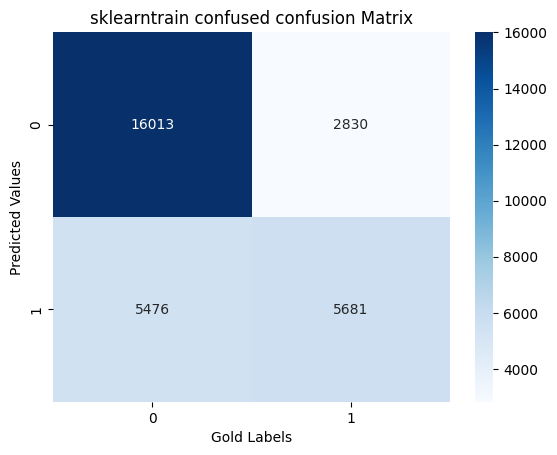

In [95]:
# Preparing the training features
X_train_features = np.column_stack((query_embedding, passage_embedding))
print("X_train_features.shape:",X_train_features.shape)

# Preparing the validation features
X_val_features = np.column_stack((query_embedding_val, passage_embedding_val))
print("X_val_features",X_val_features.shape)

epochs = 10000
penalty_type = 'l2' # Using L2 loss
literally_my_class = LogisticRegression(max_iter=epochs, penalty=penalty_type, C=0.5)

# training the model
literally_my_class.fit(X_train_features,Y_train)

# Getting validation
sk_predicted_from_test = literally_my_class.predict(X_val_features)

# Calculating the evaluation matrices (A, F1, P, R)
test_acc = metrics.accuracy_score(Y_val,sk_predicted_from_test)
print("Accuracy:", test_acc)
f1 = f1_score(Y_val, sk_predicted_from_test)
print("F1 Score:", f1)
precision = precision_score(Y_val, sk_predicted_from_test)
print("Precision:", precision)
recall = recall_score(Y_val, sk_predicted_from_test)
print("Recall:", recall)

print(f"sk_predicted_from_test: {sk_predicted_from_test}")
print(f"Y_val: {Y_val}")

# Calulating Confusion Matrix
print(metrics.confusion_matrix(Y_val, sk_predicted_from_test))
sns.heatmap(metrics.confusion_matrix(Y_val, sk_predicted_from_test),annot=True, fmt='g', cmap='Blues')
plt.title("sklearntrain confused confusion Matrix")
plt.xlabel("Gold Labels")
plt.ylabel("Predicted Values")
plt.show()

## Trend with Trained model
There wasn't any threshold value over here since logistic regression was predicting the labels (considering embeddings as features).


